In [1]:
from IPython.display import display
from model.utility.default_parameters import default_params_soros as params
from model.utility.default_initial_state import default_initial_soros as initial_state
from model.utility.initial_state_functions import fill_in_initial_state
from model.run import load_config, run, post_processing

# Fill in initial state
initial_state = fill_in_initial_state(initial_state, params)

# Set the params for runs and timesteps
number_runs = 3
number_steps = 100

# Load the experiment
exp = load_config(number_runs, params, initial_state, number_steps,
                 psub_scenario_option = "Soros")

# Run the experiment
raw = run(exp)

# Parse the raw data
df = post_processing(raw)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 24, 6, 67)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 24, 6, 67)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 27.74s


In [2]:
mapping = {'soros_short_amount': {},
          'soros_short_timing': {}}


for i, x in enumerate(params['soros_short_amount']):
    mapping["soros_short_amount"][i] = x

for i, x in enumerate(params['soros_short_timing']):
    mapping["soros_short_timing"][i] = x
    
df["soros_short_amount"] = df['subset'].map(mapping['soros_short_amount'])
df["soros_short_timing"] = df['subset'].map(mapping['soros_short_timing'])

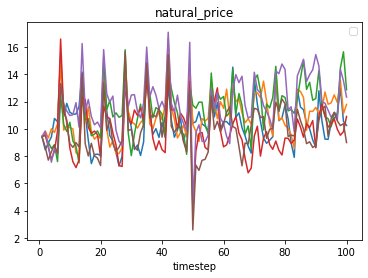

In [3]:
from model.utility.visualization import plot_all_sims, plot_grouped_variables_average

plot_all_sims(["natural_price"], df)

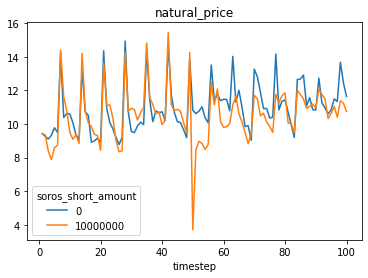

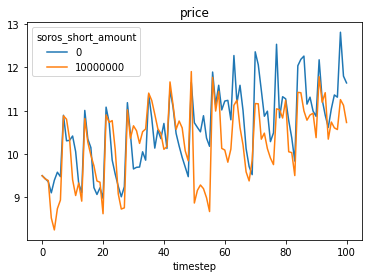

<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

In [4]:
# Plot the average values for natural price by the groups of supply and demand factor
variables_to_plot = ["natural_price", "price"]
grouping_variables = ["soros_short_amount"]

plot_grouped_variables_average(variables_to_plot,
                               grouping_variables,
                               df)

In [5]:
params['soros_short_timing']

[None, 50]